In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
import scipy.stats as stats
from hurst import compute_Hc, random_walk
import math
import datetime
import pandas_datareader.data as web
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [11]:
style.use('seaborn-ticks')

In [12]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# Collect bond index data for validation

In [13]:
bond_index_tickers = ["BAMLCC0A0CMTRIV", "BAMLCC0A1AAATRIV", "BAMLCC0A2AATRIV", "BAMLCC0A3ATRIV", 
                     "BAMLCC0A4BBBTRIV", "BAMLCC1A013YTRIV", "BAMLCC2A035YTRIV", "BAMLCC3A057YTRIV",
                     "BAMLCC4A0710YTRIV", "BAMLCC7A01015YTRIV", "BAMLCC8A015PYTRIV", "BAMLEM1BRRAAA2ACRPITRIV", 
                      "BAMLEM1RAAA2ALCRPIUSTRIV", 
                      #"BAMLEM2BRRBBBCRPITRIV", "BAMLEM2RBBBLCRPIUSTRIV",
                      #"BAMLEM3BRRBBCRPITRIV", "BAMLEM3RBBLCRPIUSTRIV", "BAMLEM4BRRBLCRPITRIV", "BAMLEM4RBLLCRPIUSTRIV", 
                      #"BAMLEM5BCOCRPITRIV", "BAMLEMALLCRPIASIAUSTRIV", "BAMLEMCBPITRIV", "BAMLEMCLLCRPIUSTRIV", 
                      #"BAMLEMEBCRPIETRIV", "BAMLEMELLCRPIEMEAUSTRIV", "BAMLEMFLFLCRPIUSTRIV", "BAMLEMHBHYCRPITRIV", 
                      #"BAMLEMHGHGLCRPIUSTRIV", "BAMLEMHYHYLCRPIUSTRIV","BAMLEMIBHGCRPITRIV", "BAMLEMLLLCRPILAUSTRIV",
                      #"BAMLEMNFNFLCRPIUSTRIV", "BAMLEMNSNFCRPITRIV","BAMLEMPBPUBSICRPITRIV", "BAMLEMPTPRVICRPITRIV",
                      #"BAMLEMPUPUBSLCRPIUSTRIV", "BAMLEMPVPRIVSLCRPIUSTRIV","BAMLEMRACRPIASIATRIV", 
                      #"BAMLEMRECRPIEMEATRIV","BAMLEMRLCRPILATRIV", "BAMLEMUBCRPIUSTRIV","BAMLEMXOCOLCRPIUSTRIV", 
                      "BAMLHE00EHYITRIV", "BAMLHYH0A0HYM2TRIV", "BAMLHYH0A1BBTRIV","BAMLHYH0A2BTRIV", "BAMLHYH0A3CMTRIV"]

In [14]:
start = datetime.datetime(2010, 4, 17)
end = datetime.datetime(2018, 1, 31)

#bond_index_tickers = ["BAMLCC0A0CMTRIV", "BAMLCC0A1AAATRIV", "BAMLCC0A2AATRIV", "BAMLCC0A3ATRIV", 
#                      "BAMLCC0A4BBBTRIV", "BAMLCC1A013YTRIV", "BAMLCC2A035YTRIV", "BAMLCC3A057YTRIV"]

bondindices = web.DataReader(bond_index_tickers, "fred", start, end)

autocors_emp = pd.DataFrame()
for col in bondindices:
    autocors_emp[col] = [bondindices[col].pct_change().autocorr(lag=lag) for lag in range(25)]

Then, calculate confidence intervals for kurtosis, and autocorrelation + absolute autocorrelation of returns. 

In [15]:
lower_k, upper_k = confidence_interval(bondindices.pct_change().kurtosis(), bondindices.pct_change().kurtosis().mean())

autocors_lower = []
autocors_upper = []

autocors_lows = []
autocors_highs = []

autocors_abs_lower = []
autocors_abs_upper = []

kurt_lower = []
kurt_upper = []
for i in range(len(autocors)):
    autocors_lows.append(autocors_emp.iloc[i].min())
    autocors_highs.append(autocors_emp.iloc[i].max())
    
    lower, upper = confidence_interval(autocors_emp.iloc[i], autocors_emp.iloc[i].mean())
    autocors_lower.append(lower)
    autocors_upper.append(upper)
    
    abs_lower, abs_upper = confidence_interval(autocors_emp.abs().iloc[i], autocors_emp.abs().iloc[i].mean())
    autocors_abs_lower.append(abs_lower)
    autocors_abs_upper.append(abs_upper)

In [21]:
# calculate hursts
hursts = []
for col in bondindices:
    H, c, data = compute_Hc(bondindices[col].dropna(), kind='price', simplified=True)
    hursts.append(H)

In [23]:
confidence_interval(hursts, np.mean(hursts))

(0.6973418814989006, 0.7342866221022218)

# How CB balance sheet policies interact with asset cycles

In [180]:
NRUNS = 1
burn_in_period = 0

In [408]:
params_nb = {"fundamental_value": 105,
              "trader_sample_size": 15, "n_traders": 500,
              "ticks": 1058, "std_fundamental": 0.01,
              "std_noise": 0.159, "w_random": 0.19,
              "strat_share_chartists": 0.70,
              "init_assets": 740, "base_risk_aversion": 1.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 7.5,
              "trades_per_tick": 1, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.10, 'money_multiplier': 2.2,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
              "qe_perc_size": 0.0001, "cb_size": 0.02, "qe_asset_index": 0}

In [409]:
scenarios = [None]
s_idx = 0

In [410]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []

for scenario in scenarios:
    trdrs = []
    orbs = []
    central_banks = []

    for seed_nb in range(NRUNS): 
        traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
        traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
        central_banks.append(central_bank_nb)
        trdrs.append(traders_nb)
        orbs.append(orderbook_nb)
    
    prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
    fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
    volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
    qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
    qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443

## Validation

In [411]:
autocors = pd.DataFrame()
for col in prices[0]:
    autocors[col] = [prices[0][col].pct_change().autocorr(lag=lag) for lag in range(25)]

In [412]:
lower_autocors = []
upper_autocors = []

for row in range(len(autocors)):
    autcor_range = autocors.iloc[row]
    lower, upper = confidence_interval(autcor_range, np.mean(autcor_range))
    lower_autocors.append(lower)
    upper_autocors.append(upper)

### Kurtosis

In [413]:
lower_k, upper_k = confidence_interval(bondindices.pct_change().kurtosis(), bondindices.pct_change().kurtosis().mean())
lower_k, upper_k

(2.3872437284006596, 5.933862512899817)

In [414]:
prices[0].pct_change().kurtosis().mean()

13.567452163153746

### Autocorrelation

#### Returns

In [415]:
confidence_interval(autocors_emp.mean(), autocors_emp.mean().mean())

(0.04238499294522907, 0.05831333270286)

In [416]:
autocors.mean().mean()

0.059235144594767725

#### Absolute returns

In [417]:
confidence_interval(autocors_emp.abs().mean(), autocors_emp.abs().mean().mean())

(0.06083040307724979, 0.07767937612929246)

In [418]:
autocors.abs().mean().mean()

0.06747896941540643

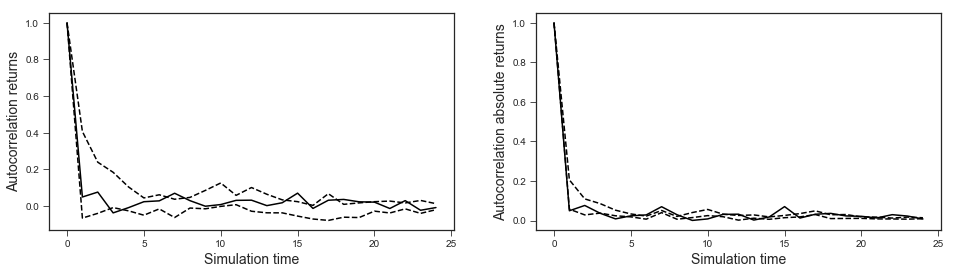

In [419]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

# 4 autocorrelation of returns
ax1.plot(autocors.index, autocors.mean(axis=1), 'k-', label='SIM Returns')
ax1.plot(autocors.index, autocors_lows, 'k--')
ax1.plot(autocors.index, autocors_highs, 'k--')
ax1.set_ylabel('Autocorrelation returns', fontsize='14')

ax2.plot(autocors.index, autocors.abs().mean(axis=1), 'k-', label='SIM Returns')
ax2.plot(autocors.index, autocors_abs_lower, 'k--')
ax2.plot(autocors.index, autocors_abs_upper, 'k--')
ax2.set_ylabel('Autocorrelation absolute returns', fontsize='14')

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    

#fig.savefig('autocorrelation_returns.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

### Long memory:

In [420]:
sim_hursts = []
for col in prices[0]:
    H, c, data = compute_Hc(prices[0][col], kind='price', simplified=True)
    sim_hursts.append(H)

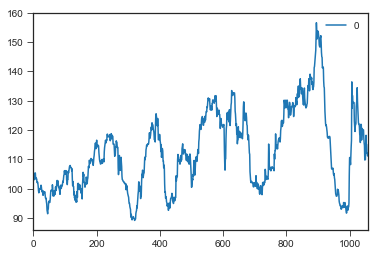

In [421]:
prices[0].plot()

In [422]:
sim_hursts

[0.48611070724463623]

# Model dynamics

fig with 
1. price to fundamentals, 
2. volume, 
3. returns, 
4. autocorrelation of returns

In [81]:
prices[0].pct_change()[0].autocorr(20)

0.010949837574071204

In [82]:
lower_c_price = []
upper_c_price = []
for row in range(len(prices[0])):
    price_range = prices[0].iloc[row] / fundamentals[s_idx].mean(axis=1)# / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

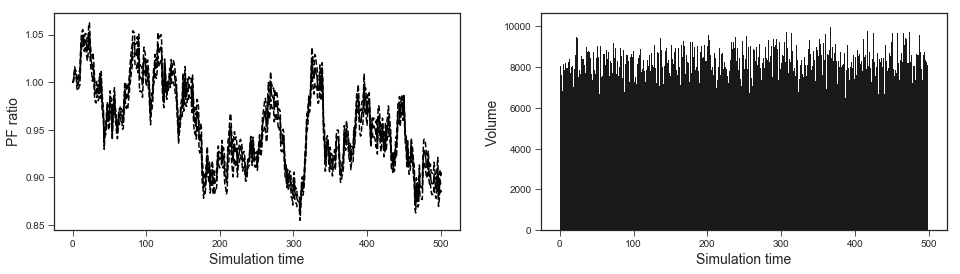

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

s_idx = 0

# 1 price to fundamentals
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1), 'k-')
ax1.plot(prices[s_idx].index, lower_c_price, 'k--')
ax1.plot(prices[s_idx].index, upper_c_price, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

# 2 volumes
ax2.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1), width=1.0, color='black', alpha=0.9)
ax2.set_ylabel('Volume', fontsize='14')


# # 3 returns
# ax3.plot(prices[0].index, prices[0].pct_change().mean(axis=1), 'k-')
# ax3.set_ylabel('Returns', fontsize='14')

# # 4 autocorrelation of returns
# ax4.plot(autocors.index, autocors.mean(axis=1), 'k-', label='SIM Returns')
# ax4.plot(autocors.index, lower_autocors, 'k--')
# ax4.plot(autocors.index, upper_autocors, 'k--')
# ax4.set_ylabel('Autocorrelation returns', fontsize='14')

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    

fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [18]:
autocors.mean().mean()

0.022176277501204007

In [20]:
autocors.abs().mean().mean()

0.08046451019106465

Text(0.5, 0, 'Simulation time')

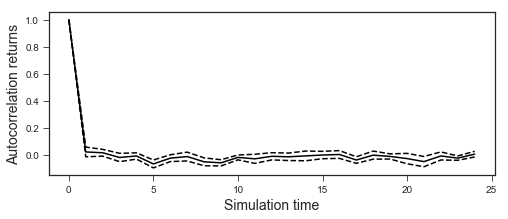

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,3))

s_idx = 0

# 1 abs autocorrelation of returns
ax1.plot(autocors.index, autocors.mean(axis=1), 'k-', label='SIM Returns')
ax1.plot(autocors.index, lower_autocors, 'k--')
ax1.plot(autocors.index, upper_autocors, 'k--')
ax1.set_ylabel('Autocorrelation returns', fontsize='14')

ax1.set_xlabel('Simulation time', fontsize='14')
    

#fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [29]:
prices[0].pct_change().kurtosis().mean()

1.8801878671359904